In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from planeIdentification import *
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import shutil
import os
import time
import itertools
import tqdm
import laspy

In [69]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"

experimentList = []
minSilhouetteList = []
avgSilhouetteList = []
maxSilhouetteList = []
n_clusters = []

baseOutputFolder = basePath + "/Results/" + neighborhood + "/Testing Plane ID/"
for experiment in os.listdir(baseOutputFolder):
    metricsFile = parcelsFolder = baseOutputFolder + experiment + "/metrics.csv"
    metricsDF = pd.read_csv(metricsFile)
    experimentList.append(experiment)
    minSilhouetteList.append(metricsDF.silhouetteScore.min())
    avgSilhouetteList.append(metricsDF.silhouetteScore.mean())
    maxSilhouetteList.append(metricsDF.silhouetteScore.max())
    n_clusters.append(metricsDF.n_clusters.mean())

allMetricsDF = pd.DataFrame({
    "experiment":experimentList,
    "min": minSilhouetteList,
    "avg": avgSilhouetteList,
    "max": maxSilhouetteList,
    "n_clustersAVG": n_clusters
})

allMetricsDF

,experiment,min,avg,max,n_clustersAVG
0,planeExtract_distance_threshold_0.5__useDistan...,0.403436,0.628785,0.942167,16.693878
1,KPlanes_distance_threshold_0.5__useDistanceSam...,0.465851,0.641456,0.970308,11.591837
2,GradientDBSCAN_distance_threshold_0.5__squareS...,0.000000,0.488682,0.933120,15.408163
3,planeExtract_distance_threshold_0.5__useDistan...,0.000000,0.000000,0.000000,1.000000
4,GradientDBSCAN_distance_threshold_0.5__squareS...,0.000000,0.203659,0.700996,12.765957
...,...,...,...,...,...
251,GradientDBSCAN_distance_threshold_0.5__squareS...,0.000000,0.374657,0.987685,3.040816
252,GradientDBSCAN_distance_threshold_0.5__squareS...,0.000000,0.481147,0.776775,137.734694
253,GradientDBSCAN_distance_threshold_0.5__squareS...,0.000000,0.342400,0.944295,3.775510
254,GradientDBSCAN_distance_threshold_0.5__squareS...,0.000000,0.243597,0.919374,2.673469


# Analitzant DBSCAN

In [ ]:
DBSCANMetrics = allMetricsDF[allMetricsDF.experiment.str.startswith("GradientDBSCAN")]
DBSCANMetrics = DBSCANMetrics.sort_values("avg", ascending=False).reset_index(drop=True)
DBSCANMetrics

,experiment,min,avg,max
0,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
1,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
2,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
3,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
4,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
...,...,...,...,...
139,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.000000,0.000000
140,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.000000,0.000000
141,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.000000,0.000000
142,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.000000,0.000000


In [19]:
bestAvgDBSCAN = DBSCANMetrics[DBSCANMetrics["avg"] == DBSCANMetrics["avg"].max()]
bestAvgDBSCAN

,experiment,min,avg,max
0,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
1,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
2,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
3,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
4,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
5,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
6,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961
7,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.605954,0.885961


In [20]:
names = bestAvgDBSCAN.experiment

squareSize = [float(name.split("squareSize_")[1].split("_")[0]) for name in names]
polar = [(name.split("polar_")[1].split("_")[0] == 'True') for name in names]
DBSCANeps = [float(name.split("DBSCANeps_")[1].split("_")[0]) for name in names]
DBSCANminSamples = [float(name.split("DBSCANminSamples_")[1].split("_")[0]) for name in names]
scores = DBSCANMetrics.avg.values

print(squareSize, polar, DBSCANeps, DBSCANminSamples)

[0.25, 0.5, 0.25, 1.0, 1.0, 2.0, 0.5, 2.0] [False, True, True, False, True, False, False, True] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


In [21]:
bestMaxDBSCAN = DBSCANMetrics[DBSCANMetrics["max"] == DBSCANMetrics["max"].max()]
bestMaxDBSCAN

,experiment,min,avg,max
64,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685
65,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685
66,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685
67,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685
68,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685
69,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685
70,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685
71,GradientDBSCAN_distance_threshold_0.5__squareS...,0.0,0.374657,0.987685


In [22]:
names = bestMaxDBSCAN.experiment

squareSize = [float(name.split("squareSize_")[1].split("_")[0]) for name in names]
polar = [(name.split("polar_")[1].split("_")[0] == 'True') for name in names]
DBSCANeps = [float(name.split("DBSCANeps_")[1].split("_")[0]) for name in names]
DBSCANminSamples = [float(name.split("DBSCANminSamples_")[1].split("_")[0]) for name in names]
scores = DBSCANMetrics.avg.values

print(squareSize, polar, DBSCANeps, DBSCANminSamples)

[2.0, 0.25, 1.0, 1.0, 2.0, 0.5, 0.5, 0.25] [True, True, False, True, False, False, True, False] [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0] [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]


# Analitzant KPlanes

In [120]:
KPlanesMetrics = allMetricsDF[allMetricsDF.experiment.str.startswith("KPlanes")]
KPlanesMetrics = KPlanesMetrics.sort_values("avg", ascending=False).reset_index(drop=True)

names = KPlanesMetrics.experiment

inlierThreshold = [float(name.split("inlierThreshold_")[1].split("_")[0]) for name in names]
useDistanceSampling = [(name.split("useDistanceSampling_")[1].split("_")[0] == 'True') for name in names]
num_iterations = [float(name.split("num_iterations_")[1].split("_")[0]) for name in names]

KPlanesMetrics["inlierThreshold"] = inlierThreshold
KPlanesMetrics["useDistanceSampling"] = useDistanceSampling
KPlanesMetrics["num_iterations"] = num_iterations
KPlanesMetrics


,experiment,min,avg,max,n_clustersAVG,inlierThreshold,useDistanceSampling,num_iterations
0,KPlanes_distance_threshold_0.5__useDistanceSam...,0.450604,0.752612,0.991793,8.551020,100.000,False,10.0
1,KPlanes_distance_threshold_0.5__useDistanceSam...,0.445972,0.749469,0.951924,9.632653,100.000,True,10.0
2,KPlanes_distance_threshold_0.5__useDistanceSam...,0.433171,0.743091,0.972742,9.020408,100.000,True,50.0
3,KPlanes_distance_threshold_0.5__useDistanceSam...,0.425772,0.741597,0.953420,8.122449,100.000,False,50.0
4,KPlanes_distance_threshold_0.5__useDistanceSam...,0.517271,0.736723,0.944192,9.551020,100.000,False,5.0
5,KPlanes_distance_threshold_0.5__useDistanceSam...,0.396767,0.732777,0.964454,8.653061,100.000,True,5.0
6,KPlanes_distance_threshold_0.5__useDistanceSam...,0.355759,0.731964,0.962636,9.571429,100.000,True,20.0
7,KPlanes_distance_threshold_0.5__useDistanceSam...,0.260210,0.731154,0.964454,9.632653,100.000,False,20.0
8,KPlanes_distance_threshold_0.5__useDistanceSam...,0.422901,0.703646,0.957359,10.673469,0.300,True,10.0
9,KPlanes_distance_threshold_0.5__useDistanceSam...,0.322560,0.703294,0.948717,10.265306,0.300,True,20.0


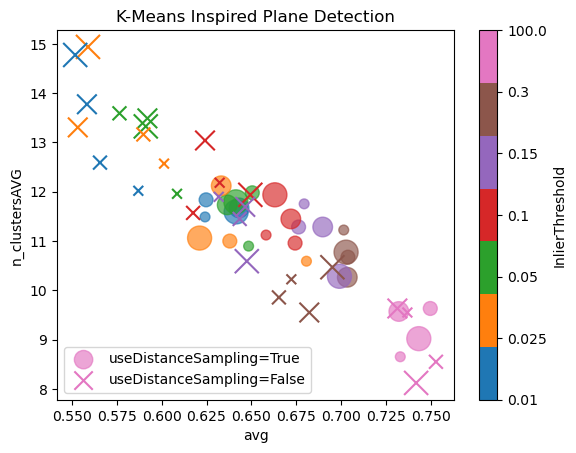

In [142]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get unique categories for "inlierThreshold" and assign colors
categories = KPlanesMetrics["inlierThreshold"].unique()
categories.sort()

colors = plt.cm.tab10(range(len(categories)))  # Use a qualitative colormap
cmap = mcolors.ListedColormap(colors)

# cmap = plt.cm.viridis  # Use the viridis colormap
# norm = mcolors.Normalize(vmin=0, vmax=len(categories) - 1)  

# Map categories to numeric values for colormap
category_to_num = {category: i for i, category in enumerate(categories)}
mapped_colors = [category_to_num[cat] for cat in KPlanesMetrics["inlierThreshold"]]

# Map num_iterations to sizes
size_mapping = {5: 50, 10: 100, 20: 200, 50: 300}  # Customize sizes as needed
sizes = [size_mapping[num] for num in KPlanesMetrics["num_iterations"]]


# Filter data by "useDistanceSampling"
data_circle = KPlanesMetrics[KPlanesMetrics["useDistanceSampling"] == True]
data_cross = KPlanesMetrics[KPlanesMetrics["useDistanceSampling"] == False]

# Plot data with circles (True)
plt.scatter(
    data_circle["avg"], 
    data_circle["n_clustersAVG"], 
    c=[category_to_num[cat] for cat in data_circle["inlierThreshold"]], 
    cmap=cmap, 
    norm=norm,  # Apply normalization for the colormap 
    marker="o",  # Circle marker
    s=[size_mapping[num] for num in data_circle["num_iterations"]],  # Size as a function of num_iterations
    label="useDistanceSampling=True",
    alpha=0.66
)

# Plot data with crosses (False)
plt.scatter(
    data_cross["avg"], 
    data_cross["n_clustersAVG"], 
    c=[category_to_num[cat] for cat in data_cross["inlierThreshold"]], 
    cmap=cmap, 
    norm=norm,  # Apply normalization for the colormap
    marker="x",  # Cross marker
    s=[size_mapping[num] for num in data_cross["num_iterations"]],
    label="useDistanceSampling=False"
)

# Add a colorbar with category labels
cbar = plt.colorbar(ticks=range(len(categories)))
cbar.ax.set_yticks(range(len(categories)))  # Set ticks at discrete category indices
cbar.ax.set_yticklabels(categories)  # Use category labels for the ticks
cbar.set_label("InlierThreshold")

# Add labels and legend
plt.xlabel("avg")
plt.ylabel("n_clustersAVG")
plt.title("K-Means Inspired Plane Detection")
plt.legend(loc = "lower left")
# plt.xlim([0,1])
# plt.ylim(bottom=0)
plt.show()


In [79]:
KPlanesMetrics["avg"]*KPlanesMetrics["avg"]

0     0.312518
1     0.304615
2     0.311846
3     0.332410
4     0.350558
5     0.349493
6     0.306192
7     0.347924
8     0.389552
9     0.320028
10    0.361620
11    0.399788
12    0.400884
13    0.344604
14    0.423065
15    0.370348
16    0.439589
17    0.421652
18    0.399142
19    0.390304
20    0.411295
21    0.461450
22    0.405098
23    0.417996
24    0.413575
25    0.411466
26    0.381325
27    0.389577
28    0.413993
29    0.451426
30    0.475570
31    0.457250
32    0.491850
33    0.433107
34    0.385800
35    0.406963
36    0.454612
37    0.420416
38    0.493672
39    0.495117
40    0.419111
41    0.463186
42    0.483038
43    0.488513
44    0.494622
45    0.451805
46    0.442567
47    0.534587
48    0.561704
49    0.535772
50    0.465325
51    0.542761
52    0.552185
53    0.536962
54    0.566425
55    0.549966
Name: avg, dtype: float64

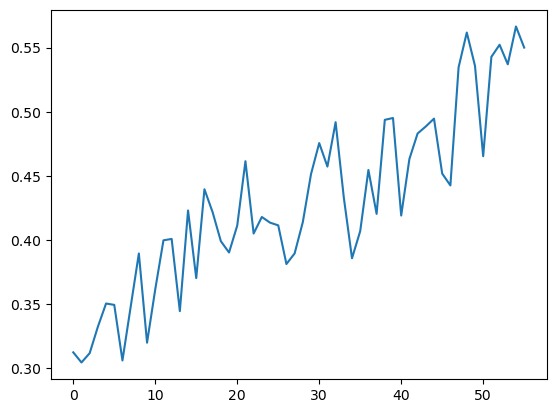

In [78]:
plt.plot(KPlanesMetrics["avg"]*KPlanesMetrics["avg"])

In [65]:
KPlanesMetrics.sort_values("min", ascending=False).reset_index(drop=True).iloc[0]

experiment             KPlanes_distance_threshold_0.5__useDistanceSam...
min                                                             0.517271
avg                                                             0.736723
max                                                             0.944192
inlierThreshold                                                    100.0
useDistanceSampling                                                False
num_iterations                                                       5.0
Name: 0, dtype: object

In [66]:
KPlanesMetrics.sort_values("avg", ascending=False).reset_index(drop=True).iloc[0]

experiment             KPlanes_distance_threshold_0.5__useDistanceSam...
min                                                             0.450604
avg                                                             0.752612
max                                                             0.991793
inlierThreshold                                                    100.0
useDistanceSampling                                                False
num_iterations                                                      10.0
Name: 0, dtype: object

In [67]:
KPlanesMetrics.sort_values("max", ascending=False).reset_index(drop=True).iloc[0]

experiment             KPlanes_distance_threshold_0.5__useDistanceSam...
min                                                             0.450604
avg                                                             0.752612
max                                                             0.991793
inlierThreshold                                                    100.0
useDistanceSampling                                                False
num_iterations                                                      10.0
Name: 0, dtype: object

# Analitzant planeExtract

In [129]:
planeExtractMetrics = allMetricsDF[allMetricsDF.experiment.str.startswith("planeExtract")]
planeExtractMetrics = planeExtractMetrics.sort_values("avg", ascending=False).reset_index(drop=True)

names = planeExtractMetrics.experiment

inlierThreshold = [float(name.split("inlierThreshold_")[1].split("_")[0]) for name in names]
useDistanceSampling = [(name.split("useDistanceSampling_")[1].split("_")[0] == 'True') for name in names]
num_iterations = [float(name.split("num_iterations_")[1].split("_")[0]) for name in names]

planeExtractMetrics["inlierThreshold"] = inlierThreshold
planeExtractMetrics["useDistanceSampling"] = useDistanceSampling
planeExtractMetrics["num_iterations"] = num_iterations
planeExtractMetrics = planeExtractMetrics[planeExtractMetrics["avg"] != 0]

planeExtractMetrics

,experiment,min,avg,max,n_clustersAVG,inlierThreshold,useDistanceSampling,num_iterations
0,planeExtract_distance_threshold_0.5__useDistan...,0.460989,0.636558,0.908528,18.591837,0.150,False,20.0
1,planeExtract_distance_threshold_0.5__useDistan...,0.454674,0.635719,0.927452,16.122449,0.300,False,50.0
2,planeExtract_distance_threshold_0.5__useDistan...,0.442578,0.635609,0.905408,18.367347,0.150,False,50.0
3,planeExtract_distance_threshold_0.5__useDistan...,0.396272,0.635230,0.927842,18.285714,0.150,True,50.0
4,planeExtract_distance_threshold_0.5__useDistan...,0.451071,0.634610,0.953120,18.530612,0.150,True,20.0
5,planeExtract_distance_threshold_0.5__useDistan...,0.463761,0.633556,0.922441,16.408163,0.300,True,20.0
6,planeExtract_distance_threshold_0.5__useDistan...,0.494878,0.631977,0.939690,18.408163,0.150,True,5.0
7,planeExtract_distance_threshold_0.5__useDistan...,0.345905,0.629423,0.950026,18.489796,0.150,True,10.0
8,planeExtract_distance_threshold_0.5__useDistan...,0.403436,0.628785,0.942167,16.693878,0.300,True,10.0
9,planeExtract_distance_threshold_0.5__useDistan...,0.426467,0.627666,0.947808,16.918367,0.300,True,5.0


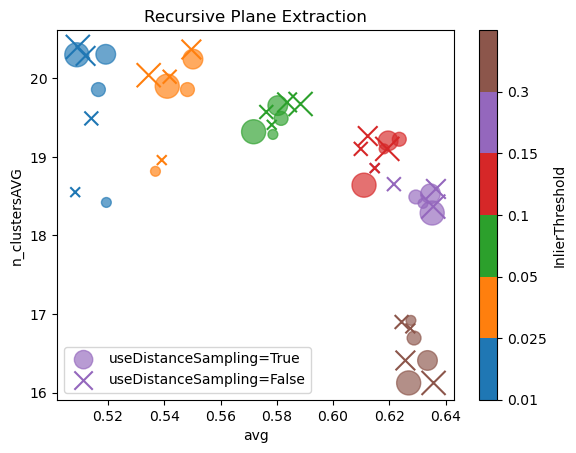

In [145]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get unique categories for "inlierThreshold" and assign colors
categories = planeExtractMetrics["inlierThreshold"].unique()
categories.sort()
colors = plt.cm.tab10(range(len(categories)))  # Use a qualitative colormap
cmap = mcolors.ListedColormap(colors)
# cmap = plt.cm.viridis  # Use the viridis colormap
# norm = mcolors.Normalize(vmin=0, vmax=len(categories) - 1)  


# Map categories to numeric values for colormap
category_to_num = {category: i for i, category in enumerate(categories)}
mapped_colors = [category_to_num[cat] for cat in planeExtractMetrics["inlierThreshold"]]

# Map num_iterations to sizes
size_mapping = {5: 50, 10: 100, 20: 200, 50: 300}  # Customize sizes as needed
sizes = [size_mapping[num] for num in planeExtractMetrics["num_iterations"]]


# Filter data by "useDistanceSampling"
data_circle = planeExtractMetrics[planeExtractMetrics["useDistanceSampling"] == True]
data_cross = planeExtractMetrics[planeExtractMetrics["useDistanceSampling"] == False]

# Plot data with circles (True)
plt.scatter(
    data_circle["avg"], 
    cmap=cmap, 
    norm = norm,
    marker="x",  # Cross marker
    s=[size_mapping[num] for num in data_cross["num_iterations"]],
    label="useDistanceSampling=False",
)

# Add a colorbar with category labels
cbar = plt.colorbar(ticks=range(len(categories)))
cbar.ax.set_yticklabels(categories)
cbar.set_label("InlierThreshold")

# Add labels and legend
plt.xlabel("avg")
plt.ylabel("n_clustersAVG")
plt.title("Recursive Plane Extraction")
plt.legend(loc = "lower left")
# plt.xlim([0,1])
# plt.ylim(bottom=0)
plt.show()


In [62]:
planeExtractMetrics.sort_values("min", ascending=False).reset_index(drop=True).iloc[0]

experiment             planeExtract_distance_threshold_0.5__useDistan...
min                                                             0.495061
avg                                                              0.61813
max                                                             0.881132
inlierThreshold                                                      0.1
useDistanceSampling                                                 True
num_iterations                                                       5.0
Name: 0, dtype: object

In [63]:
planeExtractMetrics.sort_values("avg", ascending=False).reset_index(drop=True).iloc[0]

experiment             planeExtract_distance_threshold_0.5__useDistan...
min                                                             0.460989
avg                                                             0.636558
max                                                             0.908528
inlierThreshold                                                     0.15
useDistanceSampling                                                False
num_iterations                                                      20.0
Name: 0, dtype: object

In [64]:
planeExtractMetrics.sort_values("max", ascending=False).reset_index(drop=True).iloc[0]

experiment             planeExtract_distance_threshold_0.5__useDistan...
min                                                             0.451071
avg                                                              0.63461
max                                                              0.95312
inlierThreshold                                                     0.15
useDistanceSampling                                                 True
num_iterations                                                      20.0
Name: 0, dtype: object